In [13]:
import random
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import ortho_group
import matplotlib.pyplot as plt

In [14]:
# set seeds
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [15]:
from torch.optim import Optimizer
from functools import reduce

def _armijo(f, x, gx, dx, t, alpha=0.1, beta=0.5):
    f0 = f(x, 0, dx)
    f1 = f(x, t, dx)
    while f1 > f0 + alpha * t * gx.dot(dx):
        t *= beta
        f1 = f(x, t, dx)
    return t

class SketchyGN(Optimizer):
    def __init__(self, params, lr=1.0, beta=0.999, rank=10, line_search_fn=None):
        defaults = dict(rank=rank, lr=lr, beta=beta,
                        line_search_fn=line_search_fn)
        self.rank = rank
        self.beta = beta
        self.line_search_fn = line_search_fn
        self.U = None
        self.S = None
        self.rho = None
        self.n_iters = 0
        self.n_sketch_upd = 0
        self.init_test_matrix = False

        super(SketchyGN, self).__init__(params, defaults)

        if len(self.param_groups) > 1:
            raise ValueError(
                "SketchyGN doesn't currently support per-parameter options (parameter groups)")

        if self.line_search_fn is not None and self.line_search_fn != 'armijo':
            raise ValueError("SketchyGN only supports Armijo line search")

        self._params = self.param_groups[0]['params']
        self._numel_cache = None

    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        g = torch.cat([p.grad.view(-1)
                      for group in self.param_groups for p in group['params'] if p.grad is not None])
        g = g.detach()

        # one step update
        for group_idx, group in enumerate(self.param_groups):
            # calculate the preconditioned search direction
            UTg = torch.mv(self.U.t(), g)
            dir = torch.mv(self.U, (self.S + self.rho).reciprocal()
                           * UTg) + g / self.rho - torch.mv(self.U, UTg) / self.rho

            if self.line_search_fn == 'armijo':
                x_init = self._clone_param()

                def obj_func(x, t, dx):
                    self._add_grad(t, dx)
                    loss = float(closure())
                    self._set_param(x)
                    return loss

                t = _armijo(obj_func, x_init, g, -dir, group['lr']) # Use -dir for convention
            else:
                t = group['lr']

            self.state[group_idx]['t'] = t

            # update parameters
            ls = 0
            for p in group['params']:
                np = torch.numel(p)
                dp = dir[ls:ls+np].view(p.shape)
                ls += np
                if p.grad is None:
                    continue
                p.data.add_(-dp, alpha=t)

        self.n_iters += 1

        return loss

    def update_sketch(self, v_flat, bsz):
        # Flatten the vector given by v
        # v_flat = torch.cat([component.view(-1) for component in v])
        p = v_flat.shape[0]

        # If the test matrix has not been initialized, initialize it
        if not self.init_test_matrix:
            self.Phi = torch.randn(
                (p, self.rank), device=self.param_groups[0]['params'][0].device) / (p ** 0.5)
            self.Phi = torch.linalg.qr(self.Phi, mode='reduced')[0]
            self.sketch = torch.zeros(
                (p, self.rank), device=self.param_groups[0]['params'][0].device)
            self.init_test_matrix = True

        # Update the sketch
        PhiTv = torch.mv(self.Phi.t(), v_flat)
        vvTPhi = torch.outer(v_flat, PhiTv)
        self.sketch = self.beta * self.sketch + (1 - self.beta) * bsz * vvTPhi
        self.n_sketch_upd += 1

    def update_preconditioner(self):
        sketch_debiased = self.sketch / (1 - self.beta ** self.n_sketch_upd)

        # Calculate shift
        shift = torch.finfo(sketch_debiased.dtype).eps
        sketch_shifted = sketch_debiased + shift * self.Phi

        # Calculate Phi^T * sketch_debiased * Phi (w/ shift) for Cholesky
        choleskytarget = torch.mm(self.Phi.t(), sketch_shifted)

        # Perform Cholesky, if fails, do eigendecomposition
        # The new shift is the abs of smallest eigenvalue (negative) plus the original shift
        try:
            C = torch.linalg.cholesky(choleskytarget)
        except:
            # eigendecomposition, eigenvalues and eigenvector matrix
            eigs, eigvectors = torch.linalg.eigh(choleskytarget)
            shift = shift + torch.abs(torch.min(eigs))
            # add shift to eigenvalues
            eigs = eigs + shift
            # put back the matrix for Cholesky by eigenvector * eigenvalues after shift * eigenvector^T
            C = torch.linalg.cholesky(
                torch.mm(eigvectors, torch.mm(torch.diag(eigs), eigvectors.t())))

        # try:
        #     B = torch.linalg.solve_triangular(
        #         C, sketch_shifted, upper=False, left=True)
        # # temporary fix for issue @ https://github.com/pytorch/pytorch/issues/97211
        # except:
        #     B = torch.linalg.solve_triangular(C.to('cpu'), sketch_shifted.to('cpu'), upper=False, left=True).to(C.device)
        # # B = V * S * U^T b/c we have been using transposed sketch
        # _, S, UT = torch.linalg.svd(B, full_matrices=False)
        # self.U = UT.t()
        # self.S = torch.max(torch.square(S) - shift, torch.tensor(0.0))

        try:
            B = torch.linalg.solve_triangular(
                C, sketch_shifted.t(), upper=False, left=True)
        # temporary fix for issue @ https://github.com/pytorch/pytorch/issues/97211
        except:
            B = torch.linalg.solve_triangular(C.to('cpu'), sketch_shifted.t().to(
                'cpu'), upper=False, left=True).to(C.device)
        _, S, UT = torch.linalg.svd(B, full_matrices=False)
        self.U = UT.t()
        self.S = torch.max(torch.square(S) - shift, torch.tensor(0.0))

        # Automatically set rho
        self.rho = self.S[-1]

        # print('S: ', self.S)
        # print('rho: ', self.rho)
        # print('GGN estimate: ', torch.mm(self.U, torch.mm(torch.diag(self.S), self.U.t())))

    def _numel(self):
        if self._numel_cache is None:
            self._numel_cache = reduce(lambda total, p: total + p.numel(), self._params, 0)
        return self._numel_cache

    # def _add_grad(self, step_size, update):
    #     offset = 0
    #     for p in self._params:
    #         numel = p.numel()
    #         # view as to avoid deprecated pointwise semantics
    #         p.add_(update[offset:offset + numel].view_as(p), alpha=step_size)
    #         offset += numel
    #     assert offset == self._numel()

    def _add_grad(self, step_size, update):
        offset = 0
        for p in self._params:
            numel = p.numel()
            # Avoid in-place operation by creating a new tensor
            p.data = p.data.add(
                update[offset:offset + numel].view_as(p), alpha=step_size)
            offset += numel
        assert offset == self._numel()

    def _clone_param(self):
        return [p.clone(memory_format=torch.contiguous_format) for p in self._params]

    # def _set_param(self, params_data):
    #     for p, pdata in zip(self._params, params_data):
    #         p.copy_(pdata)

    def _set_param(self, params_data):
        for p, pdata in zip(self._params, params_data):
            # Replace the .data attribute of the tensor
            p.data = pdata.data

In [16]:
class LSQ(torch.nn.Module):
    def __init__(self, n_features):
        super(LSQ, self).__init__()
        self.w = torch.nn.Linear(n_features, 1, bias=False)

    def forward(self, x):
        return self.w(x)

In [17]:
# define experiment parameters
n_train = 5000
n_test = 500
n_features = 100
n_iters = 15000

weight = np.random.normal(size=n_features)

# Xtrain = np.random.normal(size = (n_train, n_features))
# ytrain = (Xtrain @ weight)[: , np.newaxis]

# Xtest = np.sort(np.random.normal(size = (n_test, n_features)))
# ytest = (Xtest @ weight)[: , np.newaxis]

# Create a vector with polynomial decay starting at 1
decay = (np.arange(n_features) + 1) ** (-1.0)
decay = np.diag(decay)
U = ortho_group.rvs(n_train)[: , :n_features]
VT = ortho_group.rvs(n_features)
X = U @ decay @ VT

Xtrain = X[:n_train]
ytrain = (Xtrain @ weight)[: , np.newaxis]

# Xtest = X[n_train:]
# ytest = (Xtest @ weight)[: , np.newaxis]

print(f'True Hessian: {Xtrain.T @ Xtrain / n_train}')

True Hessian: [[ 5.68452123e-07  6.14098800e-07  2.08028781e-07 ...  9.04738043e-08
   4.54935270e-07  3.13811714e-07]
 [ 6.14098800e-07  9.26286418e-06  5.69873508e-07 ...  2.16071361e-06
   5.48718709e-06  1.68008852e-06]
 [ 2.08028781e-07  5.69873508e-07  1.01541385e-06 ...  2.54008324e-07
  -2.18441201e-07  6.78250338e-07]
 ...
 [ 9.04738043e-08  2.16071361e-06  2.54008324e-07 ...  1.43845159e-06
   2.43443285e-06  5.92922560e-07]
 [ 4.54935270e-07  5.48718709e-06 -2.18441201e-07 ...  2.43443285e-06
   7.95394144e-06  3.52828111e-07]
 [ 3.13811714e-07  1.68008852e-06  6.78250338e-07 ...  5.92922560e-07
   3.52828111e-07  1.57083166e-06]]


In [18]:
model = LSQ(n_features)

# specify optimizer
optimizer = SketchyGN(model.parameters(), lr=10.0, beta=0.999, rank=10, line_search_fn='armijo')
precond_update_freq = 20
sketch_warmup = 100

loss_hist = []
step_size_hist = []

Xt = torch.tensor(Xtrain, dtype=torch.float)
yt = torch.tensor(ytrain, dtype=torch.float)

torch.nn.init.zeros_(model.w.weight)

loss_function = nn.MSELoss()

for i in range(n_iters):
    model.train()

    # Warmup sketch
    if i == 0:
        for j in range(sketch_warmup):
            optimizer.zero_grad()
            output = model(Xt) + torch.randn_like(yt) # Perturb to get an unbiased estimate of GGN matrix
            loss = 0.5 * loss_function(output, yt)
            loss.backward()
            grad_flat = torch.cat([p.grad.view(-1) for p in model.parameters()])
            optimizer.update_sketch(grad_flat, Xt.shape[0])
        optimizer.update_preconditioner()

    # Take a step
    def closure():
        optimizer.zero_grad()
        output = model(Xt)
        loss = 0.5 * loss_function(output, yt)
        loss.backward()
        return loss
        
    optimizer.step(closure)

    # Get an unbiased estimate of the GGN matrix
    optimizer.zero_grad()
    output = model(Xt) + torch.randn_like(yt) # Perturb to get an unbiased estimate of GGN matrix
    loss = 0.5 * loss_function(output, yt)
    loss.backward()
    grad_flat = torch.cat([p.grad.view(-1) for p in model.parameters()])
    optimizer.update_sketch(grad_flat, Xt.shape[0])

    # Update preconditioner
    if (i + 1) % precond_update_freq == 0:
        optimizer.update_preconditioner()

    model.eval()
    output = model(Xt)
    loss = 0.5 * loss_function(output, yt).item()
    loss_hist.append(loss)

    step_size_hist.append(optimizer.state_dict()['state'][0]['t'])

    if i % 1000 == 0:
        print(f'Iteration {i} | Loss: {loss}')
        # print(optimizer.U @ torch.diag(optimizer.S) @ optimizer.U.t())
        print(optimizer.S)
        print(optimizer.rho)

Iteration 0 | Loss: 7.22002296242863e-05
tensor([2.6432e-04, 4.9023e-05, 1.5077e-05, 9.3377e-06, 4.8975e-06, 2.8004e-06,
        1.5571e-06, 1.0960e-06, 8.1784e-07, 2.6064e-07])
tensor(2.6064e-07)


Iteration 1000 | Loss: 3.8254596973321494e-18
tensor([1.9066e-04, 4.9023e-05, 1.7977e-05, 8.0595e-06, 5.3599e-06, 2.1043e-06,
        1.8295e-06, 1.0296e-06, 7.2314e-07, 3.7868e-07])
tensor(3.7868e-07)
Iteration 2000 | Loss: 3.00754971149431e-18
tensor([2.0315e-04, 5.1291e-05, 1.8162e-05, 7.9118e-06, 5.4174e-06, 2.1772e-06,
        1.9067e-06, 1.0036e-06, 8.3086e-07, 3.6019e-07])
tensor(3.6019e-07)
Iteration 3000 | Loss: 3.00754971149431e-18
tensor([1.9658e-04, 4.8056e-05, 1.8624e-05, 7.6784e-06, 5.3367e-06, 2.3272e-06,
        1.8817e-06, 9.5609e-07, 8.7870e-07, 3.8635e-07])
tensor(3.8635e-07)
Iteration 4000 | Loss: 3.00754971149431e-18
tensor([1.9309e-04, 4.7681e-05, 1.9369e-05, 8.1171e-06, 5.6277e-06, 2.2999e-06,
        1.8531e-06, 9.9474e-07, 8.1012e-07, 3.8821e-07])
tensor(3.8821e-07)
Iteration 5000 | Loss: 3.00754971149431e-18
tensor([1.9009e-04, 4.8202e-05, 1.8954e-05, 7.8808e-06, 5.6445e-06, 2.2543e-06,
        1.8028e-06, 9.8048e-07, 8.4595e-07, 3.6008e-07])
tensor(3.6008e-07

In [19]:
# # compute test loss
# with torch.no_grad():
#     Xttest = torch.tensor(Xtest, dtype=torch.float)
#     yttest = torch.tensor(ytest, dtype=torch.float)
#     output = model(Xttest)
#     loss = 0.5 * loss_function(output, yttest)
# print(f'Test Loss: {loss}')

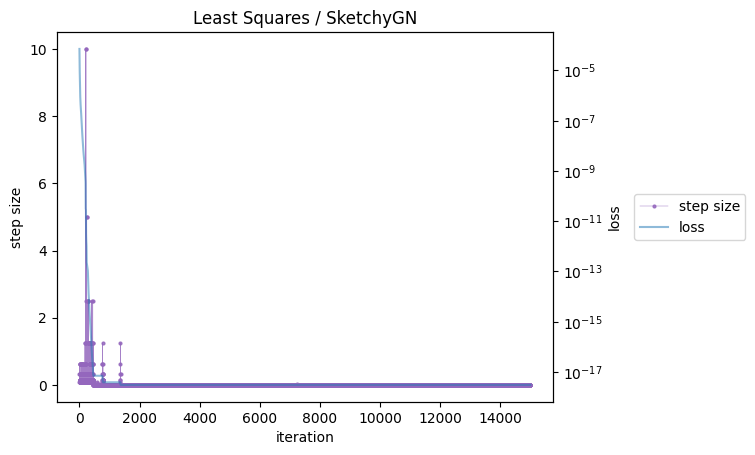

In [22]:
# make plot
fig = plt.figure()

ax1 = fig.add_subplot()
step_line = ax1.plot([float(i) for i in step_size_hist], label='step size', color='C4', alpha=0.85, marker='o', markersize=2, linestyle='solid', linewidth=0.35)
ax1.set_ylabel('step size')
ax1.set_xlabel('iteration')

ax2 = plt.twinx()
loss_line = ax2.semilogy(loss_hist, label='loss', alpha=0.5)
ax2.set_ylabel('loss')

lines = step_line + loss_line
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center left', bbox_to_anchor=(1.15, 0.5))
optimizer_name = "SketchyGN" if isinstance(optimizer, SketchyGN) else "L-BFGS"
ax1.set_title(f'Least Squares / {optimizer_name}')

plt.show()

In [21]:
# print out loss history
# loss_hist